# Train model for detection of geometric patterns

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping


import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [2]:
img_dim = (64,64)

In [3]:
def load_and_preprocess_img(folder_path):
    images = []
    labels = []

    for filename in os.listdir(folder_path): 
        if filename.endswith("jpg"):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_dim)
            img = img[:, :, np.newaxis]

            label = int(filename.split("_")[0])

            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

In [4]:
folder_path = "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_sliced_and_tilted"

In [5]:
images, labels = load_and_preprocess_img(folder_path)
print(images.shape)
print(labels.shape)

(3000, 32, 32, 1)
(3000,)


In [6]:
images = images / 255

In [7]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [8]:
y_train_one_hot = to_categorical(y_train, num_classes = 3)
y_test_one_hot = to_categorical(y_test, num_classes = 3)

In [9]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train_one_hot.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test_one_hot.shape)

x_train shape: (2400, 32, 32, 1)
y_train shape: (2400, 3)
x_test shape: (600, 32, 32, 1)
y_test shape: (600, 3)


### Example of img preprocessed

()


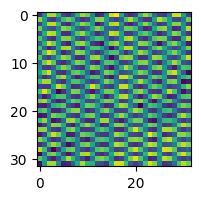

In [10]:
plt.figure(figsize=(2, 2))
plt.imshow(x_train[254,:,:])
print(y_train[254].shape)

### Model

In [12]:
model = tf.keras.Sequential([
    layers.Input(shape=(64,64,1)),
    layers.Normalization(),
    layers.Conv2D(16, (3, 3), activation='elu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='elu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.15),
    layers.Conv2D(64, (3, 3),activation='elu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3),activation='elu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.35),
    layers.Flatten(),
    layers.Dense(128, activation='elu'),

    layers.Dense(3, activation='softmax')
])

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =  0.001),       
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=tf.keras.metrics.CategoricalAccuracy())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                        

In [14]:
early_stop = EarlyStopping(monitor = "val_loss", patience=10, restore_best_weights = True)

### Run

In [15]:
history = model.fit(
    x_train,
    y_train_one_hot,
    epochs=8,
    batch_size=128,
    validation_data=(x_test, y_test_one_hot),
    callbacks=[early_stop])

Epoch 1/8

19/19 [==============================] - 2s 43ms/step - loss: 1.0989 - categorical_accuracy: 0.3725 - val_loss: 1.0580 - val_categorical_accuracy: 0.3983
Epoch 2/8
19/19 [==============================] - 1s 28ms/step - loss: 0.9893 - categorical_accuracy: 0.4879 - val_loss: 1.0007 - val_categorical_accuracy: 0.5517
Epoch 3/8
19/19 [==============================] - 1s 32ms/step - loss: 0.8026 - categorical_accuracy: 0.6225 - val_loss: 0.9136 - val_categorical_accuracy: 0.6083
Epoch 4/8
19/19 [==============================] - 1s 31ms/step - loss: 0.6809 - categorical_accuracy: 0.6988 - val_loss: 0.6497 - val_categorical_accuracy: 0.7383
Epoch 5/8
19/19 [==============================] - 1s 29ms/step - loss: 0.5651 - categorical_accuracy: 0.7471 - val_loss: 0.5221 - val_categorical_accuracy: 0.7767
Epoch 6/8
19/19 [==============================] - 1s 29ms/step - loss: 0.4722 - categorical_accuracy: 0.7879 - val_loss: 0.4904 - val_categorical_accuracy: 0.7850
Epoch 7/8
19/19

### Results

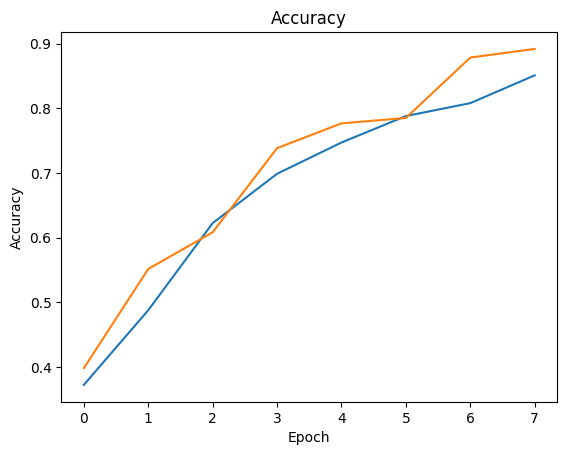

In [16]:
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')

plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(loc='upper left')
plt.show()

In [17]:
class_labels = ["check", 
                "stripe", 
                "dots"
]

19/19 [==============================] - 0s 4ms/step


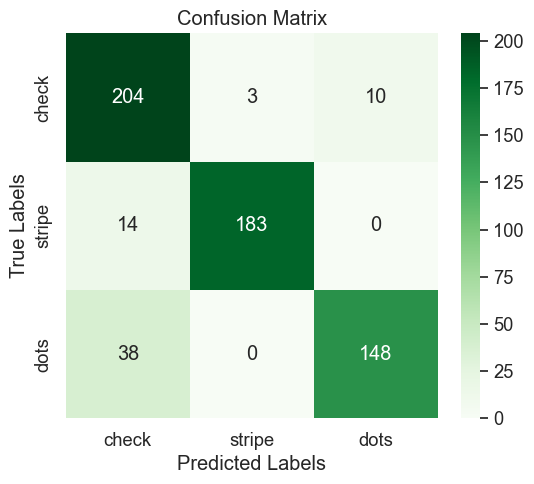

In [18]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)  
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap="Greens", 
            xticklabels= class_labels,
            yticklabels= class_labels,)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Save model

In [19]:
#model.save("geometric_24-04-03.h5")

# Testning

In [20]:
img_paths = [ "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_1.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_2.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_3.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_5.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_6.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/check_1.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/check_2.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/check_3.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/check_5.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/check_6.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/dots_1.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/dots_2.jpg",
                ]

In [21]:
def load_and_preprocess_image(image_path, img_dim):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_dim)
    img = img[:, :, np.newaxis]
    img = img / 255
    return np.expand_dims(img, axis=0)

def predict_from_image(test_image_preprocessed, model, class_labels):
    prediction = model.predict(test_image_preprocessed)
    predicted_class = np.argmax(prediction)
    predicted_probability = prediction[0, predicted_class]

    predicted_label = class_labels[predicted_class]

    print("Prediction probabilities:")
    print(prediction)
    print("Predicted class:", predicted_label)
    print("Predicted Probability: {:.2f}%".format(predicted_probability * 100))

    
for image_path in img_paths:
    test_image_preprocessed = load_and_preprocess_image(image_path, img_dim)
    
    print("\nPredictions for:", image_path)
    predict_from_image(test_image_preprocessed, model, class_labels)



Predictions for: C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_1.jpg
1/1 [==============================] - 0s 42ms/step
Prediction probabilities:
[[7.9237048e-05 9.9992073e-01 4.2476177e-08]]
Predicted class: stripe
Predicted Probability: 99.99%

Predictions for: C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_2.jpg
1/1 [==============================] - 0s 49ms/step
Prediction probabilities:
[[4.699756e-02 9.521609e-01 8.415617e-04]]
Predicted class: stripe
Predicted Probability: 95.22%

Predictions for: C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_3.jpg
1/1 [==============================] - 0s 40ms/step
Prediction probabilities:
[[0.6933511  0.30349177 0.00315715]]
Predicted class: check
Predicted Probability: 69.34%

Predictions for: C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_5.jpg
1/1 [==============================] - 0s 48ms/step
Prediction probabilities:
[[6.18482